In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hardfakevsrealfaces/data.csv
/kaggle/input/hardfakevsrealfaces/fake/fake_218.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_94.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_289.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_507.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_615.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_636.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_160.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_559.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_488.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_93.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_661.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_297.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_610.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_474.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_154.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_308.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_527.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_593.jpg
/kaggle/input/hardfakev

In [2]:
import os
import random
import shutil
import json
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Input, Concatenate, Lambda
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

import kagglehub
from collections import Counter

2025-12-26 16:03:57.009652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766765037.244871      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766765037.315428      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766765037.897340      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766765037.897393      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766765037.897396      24 computation_placer.cc:177] computation placer alr

# 1- Dataset loading

In [3]:
# Download latest version
path = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hardfakevsrealfaces


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

fake_dir = os.path.join(path, "fake")
real_dir = os.path.join(path, "real")

image_ext = (".jpg", ".jpeg", ".png")

fake_images = [f for f in os.listdir(fake_dir) if f.endswith(image_ext)]
real_images = [f for f in os.listdir(real_dir) if f.endswith(image_ext)]

print("Fake images:", len(fake_images))
print("Real images:", len(real_images))
print("Total images:", len(fake_images) + len(real_images))

Fake images: 700
Real images: 589
Total images: 1289


# 2- Train / validation / test split

In [5]:
test_size = 0.2

fake_train, fake_test = train_test_split(fake_images, test_size=test_size, random_state=42)
real_train, real_test = train_test_split(real_images, test_size=test_size, random_state=42)

work_dir = "/kaggle/working/dataset_split"
for split in ["train", "test"]:
    for cls in ["fake", "real"]:
        os.makedirs(os.path.join(work_dir, split, cls), exist_ok=True)
def copy_images(files, src_dir, dst_dir):
    for f in files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(dst_dir, f))

copy_images(fake_train, fake_dir, os.path.join(work_dir, "train", "fake"))
copy_images(real_train, real_dir, os.path.join(work_dir, "train", "real"))

# Copy test images
copy_images(fake_test, fake_dir, os.path.join(work_dir, "test", "fake"))
copy_images(real_test, real_dir, os.path.join(work_dir, "test", "real"))

train_dir = os.path.join(work_dir, "train")
test_dir  = os.path.join(work_dir, "test")

print("\nDataset split")
print(f"Train: {len(fake_train)} fake + {len(real_train)} real")
print(f"Test:  {len(fake_test)} fake + {len(real_test)} real")


Dataset split
Train: 560 fake + 471 real
Test:  140 fake + 118 real


# 3- Data exploration and visualization

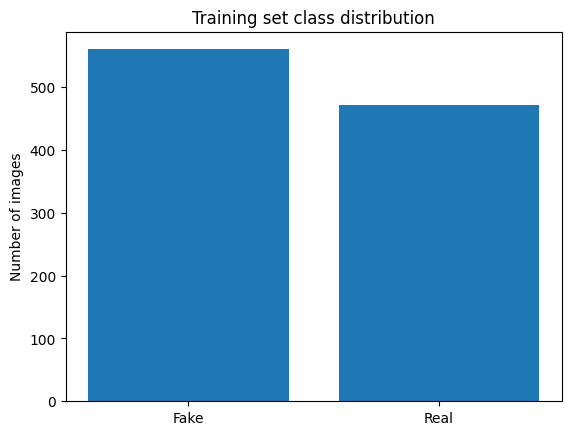

In [6]:
classes = ['Fake', 'Real']
train_counts = [len(fake_train), len(real_train)]

plt.bar(classes, train_counts)
plt.ylabel('Number of images')
plt.title('Training set class distribution')
plt.show()

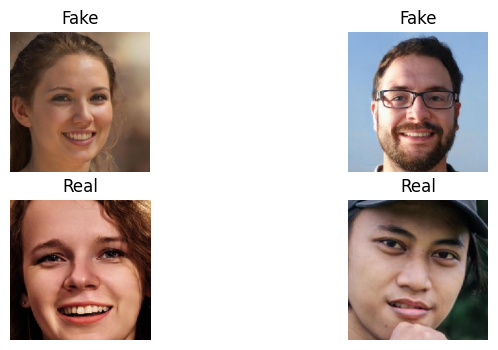

In [7]:
plt.figure(figsize=(8, 4))

# show 2 fake images
for i in range(2):
    img_path = os.path.join(train_dir, 'fake', random.choice(fake_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title('Fake')
    plt.axis('off')

# show 2 real images
for i in range(2):
    img_path = os.path.join(train_dir, 'real', random.choice(real_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 3)
    plt.imshow(img)
    plt.title('Real')
    plt.axis('off')

plt.show()

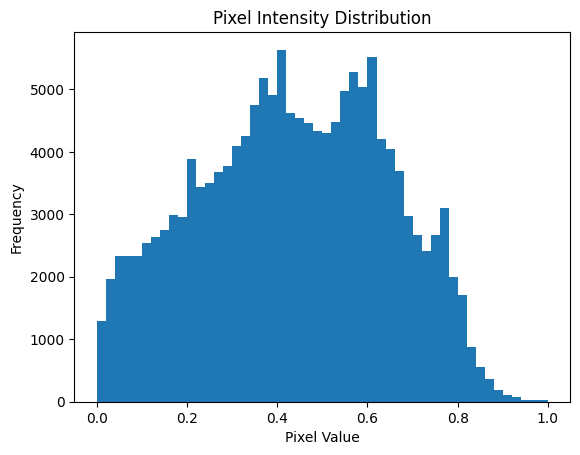

In [8]:
img = image.load_img(
    os.path.join(train_dir, 'fake', random.choice(fake_train)),
    target_size=(224,224)
)
img_array = image.img_to_array(img) / 255.0

plt.hist(img_array.flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# 4- Data Augmentation

## Data Augmentation Decision:
---------------------------
Use moderate augmentation on the training set only.
Validation and test must stay unchanged for fair evaluation
Faces can appear with small rotations or shifts
We want more variation without destroying fake/real artifacts

Augmentation Applied:
1. Rotation: ±15 degrees (faces can be slightly tilted)
2. Width/Height Shift: 10% (slight position variations)
3. Horizontal Flip: Yes (faces can be mirrored)
4. Zoom: 10% (different face sizes)
5. Fill Mode: Nearest (to avoid artifacts)

In [9]:
IMG_SIZE = 224
BATCH_SIZE = 32
N_SPLITS = 5

# Full paths and labels
all_train_files  = [os.path.join(train_dir, 'fake', f) for f in fake_train] + \
                   [os.path.join(train_dir, 'real', f) for f in real_train]
all_train_labels = [0]*len(fake_train) + [1]*len(real_train)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Generator Factory 
def make_generator(df, datagen, shuffle=True, batch_size=BATCH_SIZE):
    return datagen.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=shuffle
    )

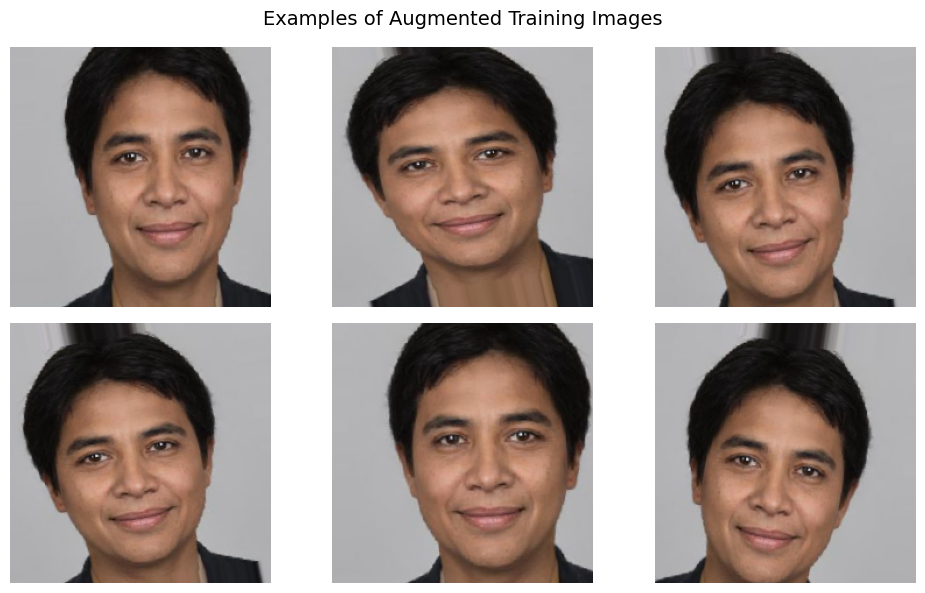

In [11]:
# VISUALIZE DATA AUGMENTATION
sample_img_path = all_train_files[0]
img = image.load_img(sample_img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, 0)

aug_iter = train_datagen.flow(img_array, batch_size=1)

plt.figure(figsize=(10, 6))
for i in range(6):
    augmented = next(aug_iter)[0]
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented)
    plt.axis('off')

plt.suptitle("Examples of Augmented Training Images", fontsize=14)
plt.tight_layout()
plt.show()

# 5- Transfer Learning Model RESNET50

In [12]:
def create_model(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 6- K-Fold Training

In [13]:
def train_single_fold(train_df, val_df):
    model = create_model()

    train_gen = make_generator(train_df, train_datagen, shuffle=True)
    val_gen   = make_generator(val_df, valid_datagen, shuffle=False)

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=0,
        class_weight=class_weights
    )

    return history, max(history.history['val_accuracy'])

In [14]:
kfold_df = pd.DataFrame({'filename': all_train_files, 'class': all_train_labels})
kfold_df['class'] = kfold_df['class'].map({0: 'fake', 1: 'real'})

# Map classes to integers for class_weight calculation
y_train_int = kfold_df['class'].map({'fake': 0, 'real': 1}).values

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9205357142857142), 1: np.float64(1.09447983014862)}


K-FOLD Model Evaluation

Evaluating model across 5 folds...

Fold 1/5... 

I0000 00:00:1766765063.157448      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766765063.158297      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


I0000 00:00:1766765074.234629      71 service.cc:152] XLA service 0x7b024c003030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766765074.234671      71 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766765074.234677      71 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766765076.171612      71 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766765081.312252      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Val Acc: 0.8068
Fold 2/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7718
Fold 3/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7524
Fold 4/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7330
Fold 5/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7524
CROSS-VALIDATION RESULTS
Fold 1: 0.8068
Fold 2: 0.7718
Fold 3: 0.7524
Fold 4: 0.7330
Fold 5: 0.7524

Mean Accuracy: 0.7633
Std Deviation: 0.0250


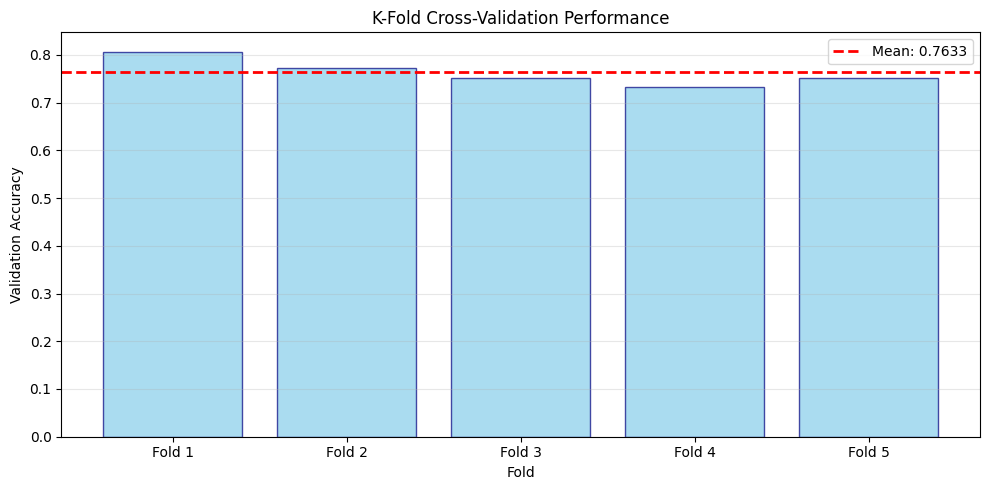

In [15]:
print("K-FOLD Model Evaluation")

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

fold_accuracies = []

print("\nEvaluating model across 5 folds...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(kfold_df, kfold_df['class'])):
    print(f"Fold {fold+1}/{N_SPLITS}...", end=" ")

    train_df = kfold_df.iloc[train_idx]
    val_df   = kfold_df.iloc[val_idx]

    history, acc = train_single_fold(train_df, val_df)
    fold_accuracies.append(acc)
    print(f"Val Acc: {acc:.4f}")

# Results
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)

print("CROSS-VALIDATION RESULTS")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"\nMean Accuracy: {mean_acc:.4f}")
print(f"Std Deviation: {std_acc:.4f}")

# Visualize K-Fold results
plt.figure(figsize=(10, 5))
folds = [f"Fold {i+1}" for i in range(N_SPLITS)]
plt.bar(folds, fold_accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.axhline(mean_acc, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {mean_acc:.4f}')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Cross-Validation Performance')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [16]:
# Use the same N_SPLITS as before
n_splits = N_SPLITS  

# X can be filenames, y is the class labels
X = kfold_df['filename']
y = kfold_df['class']

# StratifiedKFold object
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 7- Final Model Training

In [17]:
# Create a fresh 80/20 split for final training
train_df, val_df = train_test_split(
    kfold_df, 
    test_size=0.2, 
    stratify=kfold_df['class'], 
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create generators
final_train_gen = make_generator(
    train_df,
    train_datagen,
    shuffle=True
)

final_val_gen = make_generator(
    val_df,
    valid_datagen,
    shuffle=False
)

# Phase 1: Feature Extraction
print("\nPhase 1: Feature Extraction (frozen base)...")
final_model = create_model()
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history_phase1 = final_model.fit(
    final_train_gen,
    validation_data=final_val_gen,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights
)

Training samples: 824
Validation samples: 207
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.

Phase 1: Feature Extraction (frozen base)...
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 721ms/step - accuracy: 0.5145 - loss: 0.8507 - val_accuracy: 0.4589 - val_loss: 0.6962
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.4753 - loss: 0.8773 - val_accuracy: 0.4589 - val_loss: 0.6912
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.4968 - loss: 0.7744 - val_accuracy: 0.5411 - val_loss: 0.6795
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.4993 - loss: 0.7515 - val_accuracy: 0.7488 - val_loss: 0.6799
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - accuracy: 0.5031 - loss: 0.7490 - val_accuracy: 0.4638 - val_loss: 0.6886
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.5051 - loss: 0.7123 - val_accuracy: 0.7585 - val_loss: 0.6755
Epoch 7/20
26/26 

In [18]:
# Model Architecture Summary
final_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,374,917 (92.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 524,804 (2.00 MB)

# 8- Fine-Tuning

In [19]:
# Unfreeze last 15 layers
base_model = final_model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Unfrozen layers: {trainable_count}/50")

# Recompile with lower learning rate
final_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nPhase 2: Fine-tuning last 15 layers...")
history_phase2 = final_model.fit(
    final_train_gen,
    validation_data=final_val_gen,
    epochs=15,
    callbacks=[early_stop],
    class_weight=class_weights
)

# Save model
final_model.save("/kaggle/working/final_resnet50_model.keras")
print("\nModel saved!")

Unfrozen layers: 15/50

Phase 2: Fine-tuning last 15 layers...
Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 817ms/step - accuracy: 0.5950 - loss: 0.6814 - val_accuracy: 0.7536 - val_loss: 0.6595
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - accuracy: 0.7019 - loss: 0.5999 - val_accuracy: 0.8019 - val_loss: 0.6570
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.7608 - loss: 0.5563 - val_accuracy: 0.8019 - val_loss: 0.6562
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - accuracy: 0.7984 - loss: 0.4796 - val_accuracy: 0.8261 - val_loss: 0.6443
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step - accuracy: 0.7949 - loss: 0.4632 - val_accuracy: 0.8164 - val_loss: 0.6193
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.8647 - loss: 0.3893 - val_accuracy: 0.8406 - val_loss: 0.5887
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 405ms/step - accuracy: 0.8913 - loss: 0.3357 - val_accuracy: 0.6039 - val_loss: 0.5606
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━

In [20]:
# Count parameters
total_params = final_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in final_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")


Total parameters: 23,850,113
Trainable parameters: 5,782,785
Non-trainable parameters: 18,067,328


# 9- Training Curves & Analysis

In [21]:
def plot_history(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(title + " - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

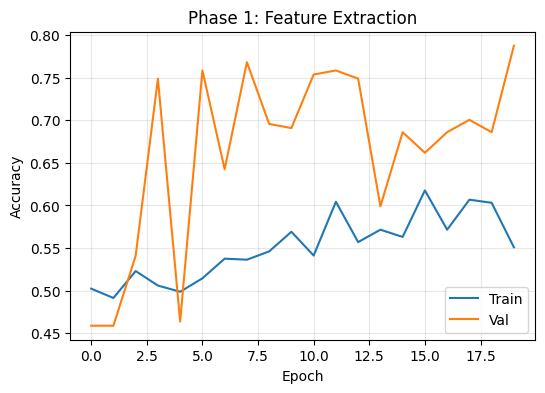

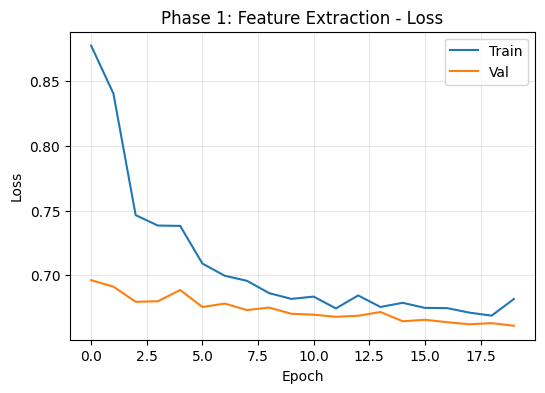

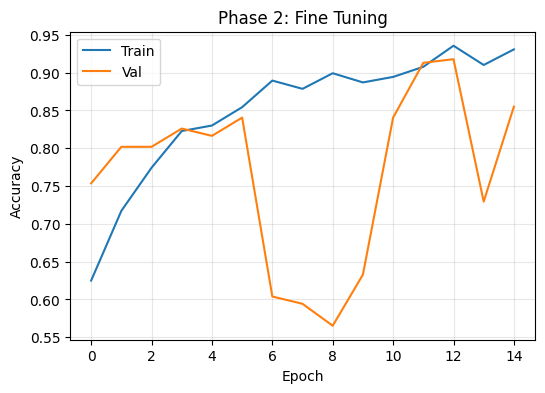

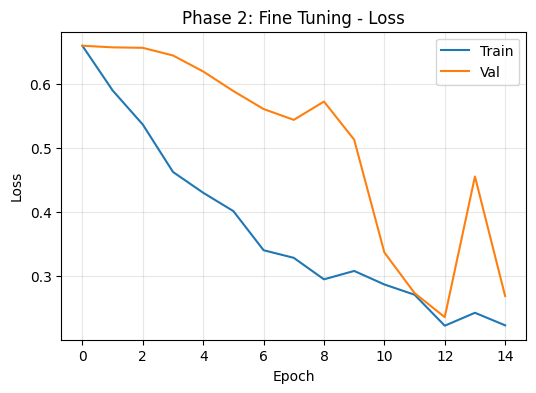

In [22]:
plot_history(history_phase1, "Phase 1: Feature Extraction")
plot_history(history_phase2, "Phase 2: Fine Tuning")

In [23]:
def overfitting_report(train_hist, val_hist, phase):
    train_acc = max(train_hist)
    val_acc   = max(val_hist)
    gap = train_acc - val_acc

    print(f"\n{phase}")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Val Accuracy: {val_acc:.4f}")
    print(f"  Gap: {gap:.4f}")

    if gap > 0.1:
        print("Significant overfitting detected")
    else:
        print("Minimal overfitting")

In [24]:
overfitting_report(
    history_phase1.history['accuracy'],
    history_phase1.history['val_accuracy'],
    "Phase 1 (Feature Extraction)"
)

overfitting_report(
    history_phase2.history['accuracy'],
    history_phase2.history['val_accuracy'],
    "Phase 2 (Fine-Tuning)"
)


Phase 1 (Feature Extraction)
  Train Accuracy: 0.6177
  Val Accuracy: 0.7874
  Gap: -0.1697
Minimal overfitting

Phase 2 (Fine-Tuning)
  Train Accuracy: 0.9357
  Val Accuracy: 0.9179
  Gap: 0.0178
Minimal overfitting


# 10- Test Set Evalution 

In [25]:
test_df = pd.DataFrame({
    'filename': [os.path.join(test_dir, 'fake', f) for f in fake_test] +
                [os.path.join(test_dir, 'real', f) for f in real_test],
    'class': [0]*len(fake_test) + [1]*len(real_test)
})

# Map classes to strings if using class_mode='binary'
test_df['class'] = test_df['class'].map({0: 'fake', 1: 'real'})

Found 258 validated image filenames belonging to 2 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 721ms/step
Best threshold: 0.3
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step

Test Accuracy : 0.9612
Test Precision: 1.0000
Test Recall   : 0.9153
Test F1-score : 0.9558

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      1.00      0.97       140
        Real       1.00      0.92      0.96       118

    accuracy                           0.96       258
   macro avg       0.97      0.96      0.96       258
weighted avg       0.96      0.96      0.96       258



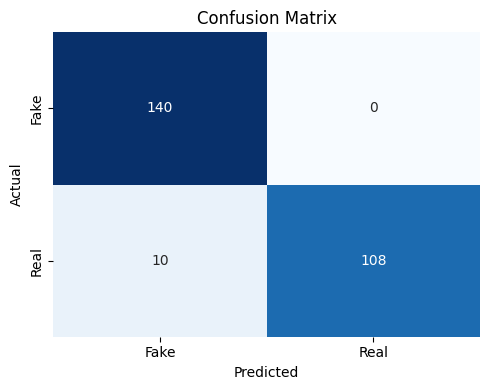

In [26]:
# Test generator
test_gen = make_generator(
    test_df,
    valid_datagen,
    shuffle=False
)

# Find best threshold on validation set 
val_probs = final_model.predict(final_val_gen).ravel()

thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = []

for t in thresholds:
    y_val_pred = (val_probs >= t).astype(int)
    f1_scores.append(f1_score(final_val_gen.classes, y_val_pred))

best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_thresh)

# Predict probabilities 
y_probs = final_model.predict(test_gen).ravel()

# Apply best threshold from validation
y_pred = (y_probs >= best_thresh).astype(int)

# True labels 
y_true = test_gen.classes

# Metrics 
test_acc  = accuracy_score(y_true, y_pred)
test_prec = precision_score(y_true, y_pred)
test_rec  = recall_score(y_true, y_pred)
test_f1   = f1_score(y_true, y_pred)

print(f"\nTest Accuracy : {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall   : {test_rec:.4f}")
print(f"Test F1-score : {test_f1:.4f}")

# Classification report 
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Confusion matrix 
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Fake','Real'], yticklabels=['Fake','Real']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [27]:
print("Train class counts:", Counter(train_df['class']))
print("Validation class counts:", Counter(val_df['class']))
print("Test class counts:", Counter(test_df['class']))

Train class counts: Counter({'fake': 448, 'real': 376})
Validation class counts: Counter({'fake': 112, 'real': 95})
Test class counts: Counter({'fake': 140, 'real': 118})


# 11- Hyperparameter Experiments 

In [28]:
# Use a subset for faster experiments (30% of training data)
experiment_df = train_df.sample(frac=0.3, random_state=42)
exp_train, exp_val = train_test_split(
    experiment_df, test_size=0.2, stratify=experiment_df['class'], random_state=42
)

## Experiment 1: Batch Size Effect

In [29]:
print("\n1. BATCH SIZE EFFECT")

batch_sizes = [16, 32, 64]
batch_results = []

for bs in batch_sizes:
    print(f"\nTesting batch size: {bs}")
    
    # Need different batch sizes, so we create new generators
    train_gen_exp = make_generator(
        exp_train,
        train_datagen,
        shuffle=True,
        batch_size=bs
    )
    
    val_gen_exp = make_generator(
        exp_val,
        valid_datagen,
        shuffle=False,
        batch_size=bs
    )

    model = create_model()
    history = model.fit(
        train_gen_exp, validation_data=val_gen_exp, 
        epochs=10, verbose=0, class_weight=class_weights
    )
    
    val_acc = max(history.history['val_accuracy'])
    batch_results.append({'batch_size': bs, 'val_accuracy': val_acc})
    print(f"  Validation Accuracy: {val_acc:.4f}")


1. BATCH SIZE EFFECT

Testing batch size: 16
Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
  Validation Accuracy: 0.5600

Testing batch size: 32
Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
  Validation Accuracy: 0.5600

Testing batch size: 64
Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
  Validation Accuracy: 0.5600


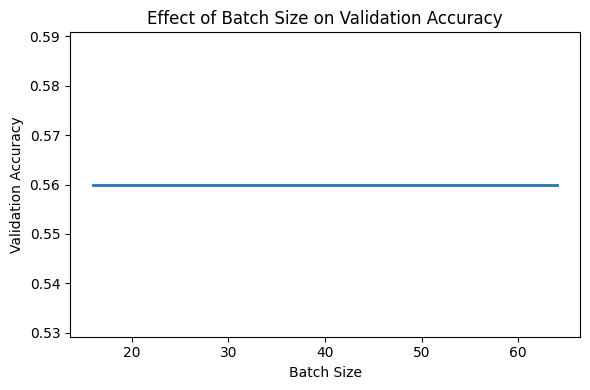

In [30]:
plt.figure(figsize=(6,4))
plt.plot(
    [r['batch_size'] for r in batch_results],
    [r['val_accuracy'] for r in batch_results],
    linewidth=2
)
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Batch Size on Validation Accuracy')
plt.tight_layout()
plt.show()

## Experiment 2: Early Stopping Effect

In [31]:
train_gen_exp = make_generator(
    exp_train,
    train_datagen,
    shuffle=True,
    batch_size=32
)

val_gen_exp = make_generator(
    exp_val,
    valid_datagen,
    shuffle=False,
    batch_size=32
)

Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.


In [32]:
print("\n2. EARLY STOPPING EFFECT")

# Without early stopping
print("\nTraining WITHOUT early stopping...")
train_gen_exp.reset()
val_gen_exp.reset()
model_no_es = create_model()
history_no_es = model_no_es.fit(
    train_gen_exp, validation_data=val_gen_exp, 
    epochs=15, verbose=0, class_weight=class_weights
)

# With early stopping
print("Training WITH early stopping (patience=5)...")
train_gen_exp.reset()  # Reset to start over
val_gen_exp.reset()
model_with_es = create_model()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_with_es = model_with_es.fit(
    train_gen_exp, validation_data=val_gen_exp, 
    epochs=15, callbacks=[early_stop], verbose=0, class_weight=class_weights
)

print(f"\nWithout ES: Final Val Acc = {history_no_es.history['val_accuracy'][-1]:.4f}")
print(f"With ES: Best Val Acc = {max(history_with_es.history['val_accuracy']):.4f}")
print(f"With ES: Stopped at epoch {len(history_with_es.history['accuracy'])}")


2. EARLY STOPPING EFFECT

Training WITHOUT early stopping...
Training WITH early stopping (patience=5)...

Without ES: Final Val Acc = 0.5600
With ES: Best Val Acc = 0.6400
With ES: Stopped at epoch 8


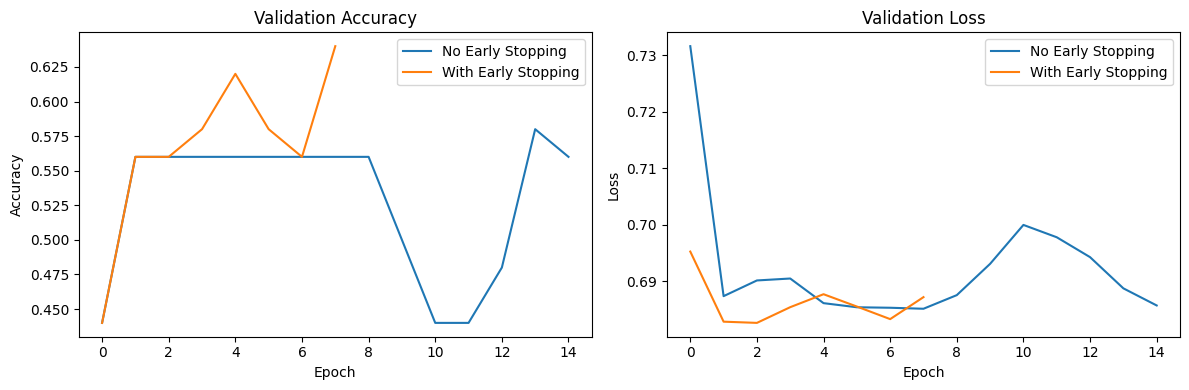

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(history_no_es.history['val_accuracy'], label='No Early Stopping')
axes[0].plot(history_with_es.history['val_accuracy'], label='With Early Stopping')
axes[0].set_title('Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history_no_es.history['val_loss'], label='No Early Stopping')
axes[1].plot(history_with_es.history['val_loss'], label='With Early Stopping')
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

## Experiment 3: Learning Rate Effect

In [34]:
print("\n3. LEARNING RATE EFFECT")

learning_rates = [0.01, 0.001, 0.0001]
lr_results = []

for lr in learning_rates:
    print(f"\nTesting learning rate: {lr}")
    
    # Create model with specific LR
    base_model = ResNet50(weights='imagenet', include_top=False, 
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Reset and train
    train_gen_exp.reset()
    val_gen_exp.reset()
    
    history = model.fit(
        train_gen_exp, validation_data=val_gen_exp, 
        epochs=10, verbose=0, class_weight=class_weights
    )
    
    val_acc = max(history.history['val_accuracy'])
    lr_results.append({'learning_rate': lr, 'val_accuracy': val_acc})
    print(f"  Best Validation Accuracy: {val_acc:.4f}")


3. LEARNING RATE EFFECT

Testing learning rate: 0.01
  Best Validation Accuracy: 0.5600

Testing learning rate: 0.001
  Best Validation Accuracy: 0.6000

Testing learning rate: 0.0001
  Best Validation Accuracy: 0.5600


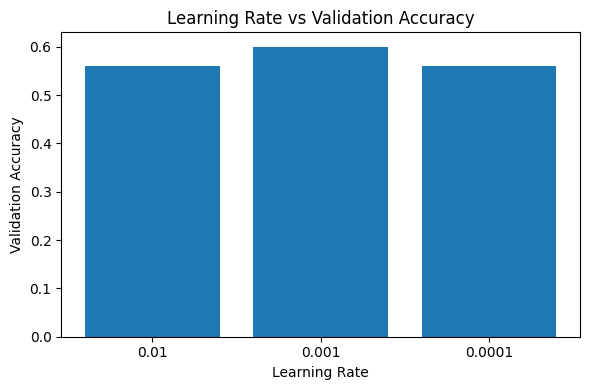

In [35]:
plt.figure(figsize=(6,4))
plt.bar(
    [str(r['learning_rate']) for r in lr_results],
    [r['val_accuracy'] for r in lr_results]
)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs Validation Accuracy')
plt.tight_layout()
plt.show()

## Experiment 4: Number of Epochs Effect

In [36]:
print("\n4. NUMBER OF EPOCHS EFFECT")

train_gen_exp.reset()
val_gen_exp.reset()

model = create_model()
history_epochs = model.fit(
    train_gen_exp, validation_data=val_gen_exp, 
    epochs=25, verbose=0, class_weight=class_weights
)

best_epoch = np.argmax(history_epochs.history['val_accuracy']) + 1
best_val_acc = max(history_epochs.history['val_accuracy'])

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Training beyond epoch {best_epoch} may lead to overfitting")


4. NUMBER OF EPOCHS EFFECT

Best validation accuracy: 0.5600 at epoch 1
Training beyond epoch 1 may lead to overfitting


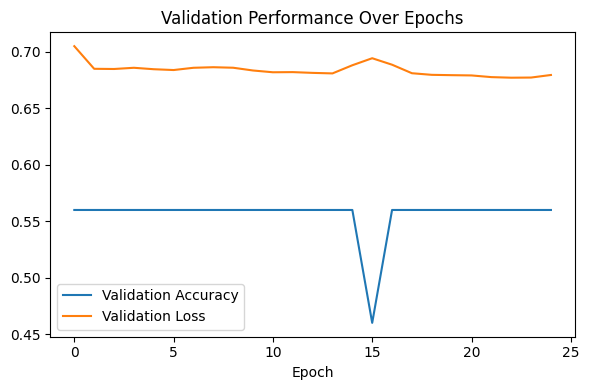

In [37]:
plt.figure(figsize=(6,4))
plt.plot(history_epochs.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_epochs.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.title('Validation Performance Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

## Summary

In [38]:
print("HYPERPARAMETER EXPERIMENT SUMMARY")
print(f"Best Batch Size: {max(batch_results, key=lambda x: x['val_accuracy'])['batch_size']}")
print(f"Early Stopping: Recommended (improves generalization)")
print(f"Best Learning Rate: {max(lr_results, key=lambda x: x['val_accuracy'])['learning_rate']}")
print(f"Optimal Epochs: {best_epoch} epochs")

HYPERPARAMETER EXPERIMENT SUMMARY
Best Batch Size: 16
Early Stopping: Recommended (improves generalization)
Best Learning Rate: 0.001
Optimal Epochs: 1 epochs


# Bonus: enhanced RESNET with custome layers

In [39]:
# original model
def create_model_original(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, 
                          input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Enhanced model with additional layers
def create_model_enhanced(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, 
                          input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        
        # BONUS: Additional layers for better feature learning
        layers.Dense(256, activation='relu'),        # ← NEW: Larger first layer
        layers.BatchNormalization(),                 # ← NEW: Batch normalization
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),        # ← Existing
        layers.BatchNormalization(),                 # ← NEW: Batch normalization
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),         # ← NEW: Additional layer
        layers.Dropout(0.3),                         # ← NEW: Light dropout
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [40]:
# Compare architectures
print("\n Original Architecture")
original = create_model_original()
original.summary()

print("\nEnhanced Architecture with bonus layers ")
enhanced = create_model_enhanced()
enhanced.summary()


 Original Architecture


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Enhanced Architecture with bonus layers 


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,009 (92.14 MB)

 Trainable params: 566,529 (2.16 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [41]:
# Train Both Models and Compare
# Use a subset for quick comparison
comparison_df = train_df.sample(frac=0.4, random_state=42)
comp_train, comp_val = train_test_split(
    comparison_df, test_size=0.2, stratify=comparison_df['class'], random_state=42
)

comp_train_gen = make_generator(
    comp_train,
    train_datagen,
    shuffle=True
)

comp_val_gen = make_generator(
    comp_val,
    valid_datagen,
    shuffle=False
)

# Train original
print("\n1. Training ORIGINAL model...")
comp_train_gen.reset()
comp_val_gen.reset()
model_orig = create_model_original()
history_orig = model_orig.fit(
    comp_train_gen, validation_data=comp_val_gen,
    epochs=15, verbose=1, class_weight=class_weights
)

# Train enhanced
print("\n2. Training ENHANCED model...")
comp_train_gen.reset()
comp_val_gen.reset()
model_enh = create_model_enhanced()
history_enh = model_enh.fit(
    comp_train_gen, validation_data=comp_val_gen,
    epochs=15, verbose=1, class_weight=class_weights
)

Found 264 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.

1. Training ORIGINAL model...
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4905 - loss: 0.9264 - val_accuracy: 0.4545 - val_loss: 0.6971
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.4867 - loss: 0.8674 - val_accuracy: 0.5455 - val_loss: 0.6879
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.5203 - loss: 0.8336 - val_accuracy: 0.5455 - val_loss: 0.6886
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.4937 - loss: 0.8492 - val_accuracy: 0.5758 - val_loss: 0.6903
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.4931 - loss: 0.8238 - val_accuracy: 0.5455 - val_loss: 0.6859
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.4489 - loss: 0.8936 - val_accuracy: 0.5455 - val_loss: 0.6863
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4915 - loss: 0.8290 - val_accura

In [42]:
# Results summary
print("COMPARISON RESULTS")
print(f"Original Model - Best Val Acc: {max(history_orig.history['val_accuracy']):.4f}")
print(f"Enhanced Model - Best Val Acc: {max(history_enh.history['val_accuracy']):.4f}")

improvement = max(history_enh.history['val_accuracy']) - max(history_orig.history['val_accuracy'])
print(f"\nImprovement: {improvement*100:+.2f}%")

print("\nEnhancements made:")
print("Added BatchNormalization layers for stable training")
print("Increased first Dense layer to 256 units")
print("Added extra Dense layer (64 units) for finer feature learning")
print("Adjusted dropout rates for better regularization")

if improvement > 0:
    print("Enhanced architecture shows improvement")
else:
    print("Similar performance, both architectures work well")

COMPARISON RESULTS
Original Model - Best Val Acc: 0.5758
Enhanced Model - Best Val Acc: 0.7727

Improvement: +19.70%

Enhancements made:
Added BatchNormalization layers for stable training
Increased first Dense layer to 256 units
Added extra Dense layer (64 units) for finer feature learning
Adjusted dropout rates for better regularization
Enhanced architecture shows improvement


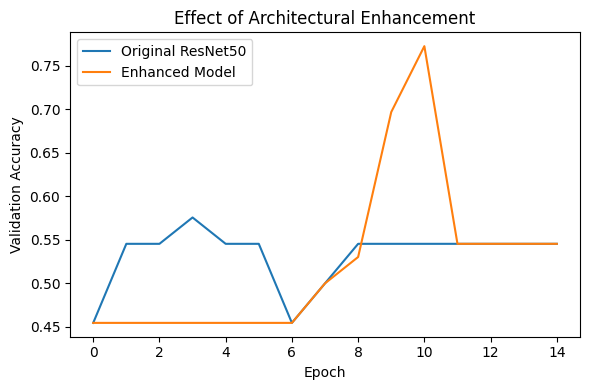

In [43]:
plt.figure(figsize=(6,4))
plt.plot(history_orig.history['val_accuracy'], label='Original ResNet50')
plt.plot(history_enh.history['val_accuracy'], label='Enhanced Model')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Architectural Enhancement')
plt.legend()
plt.tight_layout()
plt.show()

# Bonus: Ensamble arch RESNET50 + MOBILENETV2

In [44]:
def create_resnet_model(img_size=IMG_SIZE):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


def create_mobilenet_model(img_size=IMG_SIZE):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [45]:
# ENSEMBLE MODEL
def create_ensemble_model(img_size=IMG_SIZE):
    """
    Ensemble model combining ResNet50 and MobileNetV2.
    Each branch applies its own proper preprocessing.
    """
    # Input expects raw pixels [0, 255] from generator
    input_layer = Input(shape=(img_size, img_size, 3))

    # -------- ResNet50 branch --------
    resnet_input = Lambda(resnet_preprocess)(input_layer)
    resnet_base = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    resnet_base.trainable = False

    resnet_branch = resnet_base(resnet_input)
    resnet_branch = layers.GlobalAveragePooling2D()(resnet_branch)
    resnet_branch = layers.Dense(64, activation='relu')(resnet_branch)

    # -------- MobileNetV2 branch --------
    mobilenet_input = Lambda(mobilenet_preprocess)(input_layer)
    mobilenet_base = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    mobilenet_base.trainable = False

    mobilenet_branch = mobilenet_base(mobilenet_input)
    mobilenet_branch = layers.GlobalAveragePooling2D()(mobilenet_branch)
    mobilenet_branch = layers.Dense(64, activation='relu')(mobilenet_branch)

    # -------- Combine branches --------
    combined = Concatenate()([resnet_branch, mobilenet_branch])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    combined = layers.Dense(64, activation='relu')(combined)
    combined = layers.Dropout(0.3)(combined)

    output = layers.Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [46]:
# DATA SPLIT FOR COMPARISON
print("\nPreparing data for comparison")
comp_train, comp_val = train_test_split(
    comparison_df,
    test_size=0.2,
    stratify=comparison_df['class'],
    random_state=42
)

print(f"Comparison set: {len(comp_train)} train, {len(comp_val)} val")


# GENERATORS FOR SINGLE MODELS (WITH RESCALING)
comp_train_gen = make_generator(
    comp_train,
    train_datagen,
    shuffle=True
)

comp_val_gen = make_generator(
    comp_val,
    valid_datagen,
    shuffle=False
)


# ENSEMBLE-ONLY GENERATORS (NO RESCALING - RAW PIXELS)
# Ensemble needs raw pixels [0, 255] for proper preprocessing
ensemble_train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
    # NO rescale parameter!
)

ensemble_val_datagen = ImageDataGenerator()  # No augmentation for validation

ensemble_train_gen = make_generator(
    comp_train,
    ensemble_train_datagen,
    shuffle=True
)

ensemble_val_gen = make_generator(
    comp_val,
    ensemble_val_datagen,
    shuffle=False
)


Preparing data for comparison
Comparison set: 264 train, 66 val
Found 264 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.


In [47]:
# TRAIN ALL MODELs
print("TRAINING COMPARISON")

results = {}

print("\n1. Training ResNet50...")
comp_train_gen.reset()
comp_val_gen.reset()
model_resnet = create_resnet_model()
history_resnet = model_resnet.fit(
    comp_train_gen,
    validation_data=comp_val_gen,
    epochs=15,
    verbose=1,
    class_weight=class_weights
)
results['ResNet50'] = max(history_resnet.history['val_accuracy'])
print(f"   Best Val Acc: {results['ResNet50']:.4f}")

print("\n2. Training MobileNetV2...")
comp_train_gen.reset()
comp_val_gen.reset()
model_mobile = create_mobilenet_model()
history_mobile = model_mobile.fit(
    comp_train_gen,
    validation_data=comp_val_gen,
    epochs=15,
    verbose=1,
    class_weight=class_weights
)
results['MobileNetV2'] = max(history_mobile.history['val_accuracy'])
print(f"   Best Val Acc: {results['MobileNetV2']:.4f}")

print("\n3. Training Ensemble (ResNet50 + MobileNetV2)...")
ensemble_train_gen.reset()
ensemble_val_gen.reset()
model_ensemble = create_ensemble_model()
history_ensemble = model_ensemble.fit(
    ensemble_train_gen,
    validation_data=ensemble_val_gen,
    epochs=15,
    verbose=1,
    class_weight=class_weights
)
results['Ensemble'] = max(history_ensemble.history['val_accuracy'])
print(f"   Best Val Acc: {results['Ensemble']:.4f}")

TRAINING COMPARISON

1. Training ResNet50...
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4536 - loss: 1.0148 - val_accuracy: 0.5303 - val_loss: 0.6942
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.5513 - loss: 0.8594 - val_accuracy: 0.5455 - val_loss: 0.6928
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.5573 - loss: 0.8887 - val_accuracy: 0.5455 - val_loss: 0.6922
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.5314 - loss: 0.8222 - val_accuracy: 0.5455 - val_loss: 0.6909
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.4534 - loss: 0.9981 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.5389 - loss: 0.8195 - val_accuracy: 0.5455 - val_loss: 0.6915
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.4683 - loss: 0.8590 - val_accuracy: 0.5455 - val_loss: 0.6887
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.5417 - loss

2025-12-26 16:40:19.626021: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 16:40:19.762442: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/9 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.5137 - loss: 1.0288

2025-12-26 16:40:30.682699: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 16:40:30.818566: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5163 - loss: 0.9561

2025-12-26 16:40:45.725930: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 16:40:45.863072: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 16:40:45.998199: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5177 - loss: 0.9470 - val_accuracy: 0.6364 - val_loss: 0.6404
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.5531 - loss: 0.8249 - val_accuracy: 0.6970 - val_loss: 0.5607
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.6893 - loss: 0.5746 - val_accuracy: 0.7576 - val_loss: 0.4815
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.7671 - loss: 0.5197 - val_accuracy: 0.8636 - val_loss: 0.4063
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.7662 - loss: 0.4734 - val_accuracy: 0.8636 - val_loss: 0.3619
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.8029 - loss: 0.4291 - val_accuracy: 0.8788 - val_loss: 0.3266
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.8201 - loss: 0.3788 - val_accuracy: 0.9242 - val_loss: 0.3001
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.9140 - loss: 0.2690 - val_accuracy: 0.9242 - val_loss: 0.2732
Epoch

In [48]:
# RESULTS SUMMARY
print("ENSEMBLE RESULTS")

for name, acc in results.items():
    print(f"{name:15s}: {acc:.4f}")

best_model = max(results, key=results.get)
print(f"\nBest Model: {best_model} ({results[best_model]:.4f})")

improvement = results['Ensemble'] - max(results['ResNet50'], results['MobileNetV2'])
print(f"Ensemble Improvement: {improvement*100:+.2f}%")

print("\nKey Points:")
print("ResNet50 and MobileNetV2 use DIFFERENT preprocessing")
print("Ensemble applies correct preprocessing to each branch")
print("Both branches learn complementary features")
print(" Final decision combines both architectures")

ENSEMBLE RESULTS
ResNet50       : 0.5455
MobileNetV2    : 0.9545
Ensemble       : 0.9697

Best Model: Ensemble (0.9697)
Ensemble Improvement: +1.52%

Key Points:
ResNet50 and MobileNetV2 use DIFFERENT preprocessing
Ensemble applies correct preprocessing to each branch
Both branches learn complementary features
 Final decision combines both architectures


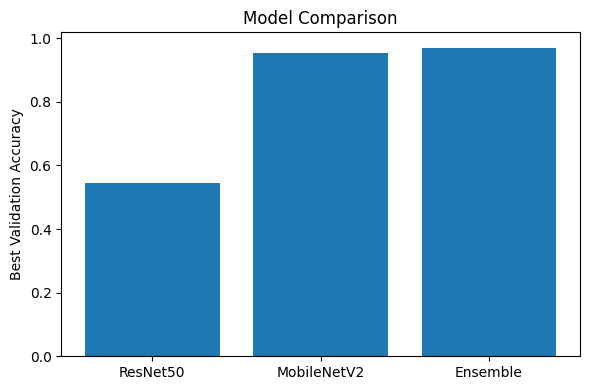

In [49]:
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values())
plt.ylabel('Best Validation Accuracy')
plt.title('Model Comparison')
plt.tight_layout()
plt.show()